In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

In [2]:
def unsqueeze(axis):

    def unsqueeze_dec(fn):

        def new_fn(input):
            return fn(tf.expand_dims(input, axis=axis))

        return new_fn

    return unsqueeze_dec

In [3]:
def value_and_gradient(value_fn):

    @tf.function
    def value_and_gradient_fn(x):

        # Equivalent to `tfp.math.value_and_gradient(value_fn, x)`, with the
        # only difference that the gradients preserve their `dtype` rather than
        # casting to `tf.float32`, which is problematic for scipy.optimize
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(x)
            val = value_fn(x)

        grad = tape.gradient(val, x)

        return val, grad

    return value_and_gradient_fn

In [4]:
def numpy_io(fn):

    def new_fn(*args):

        new_args = map(tf.convert_to_tensor, args)
        outputs = fn(*new_args)
        new_outputs = [output.numpy() for output in outputs]

        return new_outputs

    return new_fn

In [5]:
tfd = tfp.distributions
kernels = tfp.math.psd_kernels
kernel_cls = kernels.MaternFiveHalves

num_index_points = 512
num_features = 1
num_samples = 10

noise_variance = 0.05

num_epochs = 200
learning_rate = 0.05
beta_1 = 0.5
beta_2 = 0.99
jitter = 1e-6

seed = 8888
random_state = np.random.RandomState(seed)

In [6]:
def forrester(x):
    """
    Forrester's.
    """
    # return (6.0*x-2.0)**2 * np.sin(12.0 * x - 4.0)
    return np.sin(3.0*x) + x**2 - 0.7*x

In [7]:
x_min, x_max = -1.0, 2.0
X_grid = np.linspace(x_min, x_max, num_index_points).reshape(-1, num_features)

In [8]:
eps = noise_variance * random_state.randn(num_samples, num_features)

X = x_min + (x_max - x_min) * random_state.rand(num_samples, num_features)
Y = forrester(X) + eps
y = Y.squeeze(axis=-1)

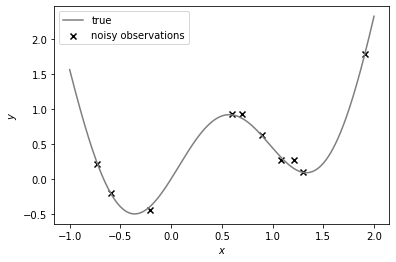

In [9]:
fig, ax = plt.subplots()

ax.plot(X_grid, forrester(X_grid), label="true", color="tab:gray")
ax.scatter(X, y, marker='x', color='k', label="noisy observations")

ax.set_xlabel(r'$x$')
ax.set_ylabel(r"$y$")

ax.legend()

plt.show()

In [10]:
amplitude = tfp.util.TransformedVariable(
    1.0, bijector=tfp.bijectors.Softplus(), dtype="float64", name='amplitude')
length_scale = tfp.util.TransformedVariable(
    0.5, bijector=tfp.bijectors.Softplus(), dtype="float64", name='length_scale')
observation_noise_variance = tfp.util.TransformedVariable(
    1e-1, bijector=tfp.bijectors.Softplus(), dtype="float64",
    name='observation_noise_variance')

In [11]:
kernel = kernel_cls(amplitude=amplitude, length_scale=length_scale)
gp = tfd.GaussianProcess(
    kernel=kernel, index_points=X,
    observation_noise_variance=observation_noise_variance)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                     beta_1=beta_1, beta_2=beta_2)

In [12]:
for epoch in range(num_epochs):

    with tf.GradientTape() as tape:
        nll = - gp.log_prob(y)

    gradients = tape.gradient(nll, gp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, gp.trainable_variables))

In [13]:
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel, index_points=X_grid,
    observation_index_points=X, observations=y,
    observation_noise_variance=observation_noise_variance, jitter=jitter)

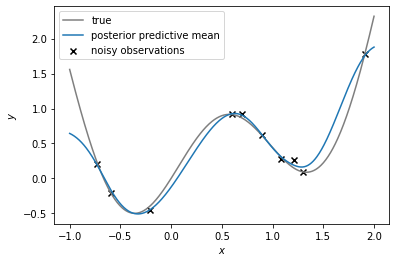

In [14]:
fig, ax = plt.subplots()

ax.plot(X_grid, forrester(X_grid), label="true", color="tab:gray")
ax.scatter(X, y, marker='x', color='k', label="noisy observations")

ax.plot(X_grid, gprm.mean(), label="posterior predictive mean")

ax.legend()

ax.set_xlabel(r'$x$')
ax.set_ylabel(r"$y$")

plt.show()

In [15]:
def convert(func):

    @numpy_io
    @value_and_gradient
    @unsqueeze(axis=1)
    def new_func(x):
        return func(index_points=x)

    return new_func

In [16]:
func = convert(gprm.mean)
func(np.float64([0.5]))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


[0.8568218412464763, array([1.07929374])]

In [17]:
from scipy.optimize import minimize

In [18]:
initial_position = np.float64([1.8])

In [19]:
x_hist = [initial_position]

In [20]:
res = minimize(func, x0=initial_position, jac=True, bounds=[(x_min, x_max)], 
               method="L-BFGS-B", callback=x_hist.append)
res

      fun: -0.5087109244301322
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.01153765e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 9
      nit: 4
     njev: 9
   status: 0
  success: True
        x: array([-0.32712357])

In [21]:
X_hist = np.vstack(x_hist)
# Y_hist = model(X_hist)
Y_hist = gprm.mean(index_points=X_hist)

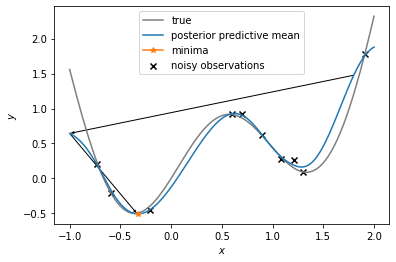

In [22]:
fig, ax = plt.subplots()

ax.plot(X_grid, forrester(X_grid), label="true", color="tab:gray")
ax.scatter(X, y, marker='x', color='k', label="noisy observations")

ax.plot(X_grid, gprm.mean(), label="posterior predictive mean")

ax.quiver(X_hist[:-1], Y_hist[:-1],
          X_hist[1:] - X_hist[:-1],
          Y_hist[1:] - Y_hist[:-1],
          scale_units='xy', angles='xy', scale=1.0, width=3e-3)

ax.plot(res.x, res.fun, c="tab:orange", marker='*', label="minima")

ax.legend()

ax.set_xlabel(r'$x$')
ax.set_ylabel(r"$y$")

plt.show()

In [67]:
initial_position = np.float64([0.25])

In [68]:
y_samples = tfd.GaussianProcessRegressionModel(
    kernel=kernel, index_points=initial_position.reshape(-1, 1),
    observation_index_points=X, observations=y,
    observation_noise_variance=observation_noise_variance, jitter=jitter).sample() # sample_shape=(5,)
y_samples

<tf.Tensor: shape=(), dtype=float64, numpy=1.1106732145648475>

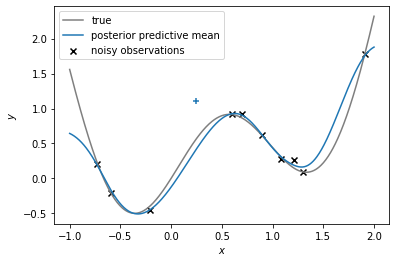

In [69]:
fig, ax = plt.subplots()

ax.plot(X_grid, forrester(X_grid), label="true", color="tab:gray")
ax.scatter(X, y, marker='x', color='k', label="noisy observations")

ax.plot(X_grid, gprm.mean(), label="posterior predictive mean")

ax.scatter(initial_position, y_samples, marker="+")

ax.legend()

ax.set_xlabel(r'$x$')
ax.set_ylabel(r"$y$")

plt.show()

In [70]:
X_next = np.vstack((X, initial_position))
y_next = np.hstack((y, y_samples))

In [71]:
gprm_next = tfd.GaussianProcessRegressionModel(
    kernel=kernel, index_points=X_grid,
    observation_index_points=X_next, observations=y_next,
    observation_noise_variance=observation_noise_variance, jitter=jitter)

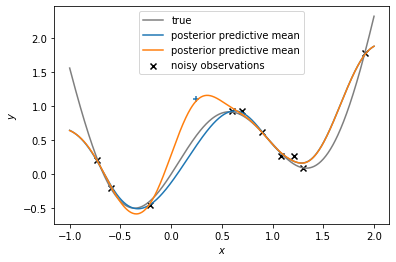

In [72]:
fig, ax = plt.subplots()

ax.plot(X_grid, forrester(X_grid), label="true", color="tab:gray")
ax.scatter(X, y, marker='x', color='k', label="noisy observations")

ax.plot(X_grid, gprm.mean(), label="posterior predictive mean")
ax.plot(X_grid, gprm_next.mean(), label="posterior predictive mean")

ax.scatter(initial_position, y_samples, marker="+")

ax.legend()

ax.set_xlabel(r'$x$')
ax.set_ylabel(r"$y$")

plt.show()